# Evaluation of Methane Emissions Inventory Using Satellite Flux Inversions

### Authors: Sudhanshu Pandey, John Worden

### Correspondence: Sudhanshu Pandey (sudhanshu.pandey@jpl.nasa.gov)

Jet Propulsion Laboratory, California Institute of Technology, Pasadena, CA 91109, USA


**Copyright** [2024], by the California Institute of Technology. ALL RIGHTS RESERVED. United States Government Sponsorship acknowledged. Any commercial use must be negotiated with the Office of Technology Transfer at the California Institute of Technology.

This software may be subject to U.S. export control laws. By accepting this software, the user agrees to comply with all applicable U.S. export laws and regulations. User has the responsibility to obtain export licenses, or other export authority as may be required before exporting such information to foreign countries or providing access to foreign persons.

## Executive Summary

This notebook presents a comprehensive evaluation of gridded methane emission inventories using atmospheric flux inversions based on GOSAT (Greenhouse gases Observing SATellite) concentration measurements. It demonstrates how to account for the truth sensitivity (averaging kernel) of atmospheric flux inversions and provides an in-depth comparison between bottom-up inventories and satellite-derived emissions. The GOSAT flux inversion data utilized are sourced from Qu et al. (2024).

### Key Concepts

- **Bayesian Method:**
  - The flux inversion data are spatially and temporally disaggregated using a Bayesian framework, as described in Worden et al. (2023).
- **Averaging Kernel (AK):**
  - A metric that quantifies the extent to which flux inversions can "see" or detect the actual emissions of gases like methane in the atmosphere.
  - Indicates how accurately the inversion captures true emission amounts, given the satellite data coverage and the uncertainties in observational data and transport models.
  - Reflects the degree to which the flux inversion estimate (posterior) depends on actual observations versus prior emission estimates.



---

## Intended User

The intended user should ideally be knowledgeable about inverse problems or possess the technical skills to learn the basics of inverse problems.

---


### Accounting for the Averaging Kernel (Truth Sensitivity) in Atmospheric Flux Inversion Emission Estimates

Top-down approaches like satellite-based flux inversions play a crucial role in estimating greenhouse gas emissions by constraining them with atmospheric concentration measurements. These methods enable the evaluation and enhancement of bottom-up emission inventories. Flux inversions use chemical transport models to link atmospheric concentration data—gathered from satellites or ground-based stations—to the underlying emissions. Within a Bayesian framework, they integrate prior emission estimates with observational data to generate optimal posterior emission estimates.

The posterior emission estimates from flux inversions can assess the accuracy of bottom-up inventories concerning annual total emissions, spatial and sectoral emission distributions, and emission trends over time. However, when comparing these estimates to inventories, it's essential to consider the flux inversion's sensitivity to the true emissions. This sensitivity is represented by the **averaging kernel matrix** (also known as the inversion operator).

#### Posterior Solution of a Flux Inversion

The posterior solution of a flux inversion is essentially an error-weighted average of prior emissions and observational data. To evaluate an emission inventory using flux inversion results, we apply the flux inversion operator to the inventory emissions. In this context, we assume that the inventory represents the true emissions for comparison purposes. The estimated emissions are calculated as:

$$
x_{\text{inv\_est}} = x_a + A (x_{\text{inv}} - x_a)
$$

**Where:**
- $ x_{\text{inv\_est}} $: Estimated emissions after applying the flux inversion operator to the inventory emissions.
- $ x_a $: Prior emissions used in the inversion.
- $ A $: Averaging kernel matrix representing the flux inversion operator.
- $ x_{\text{inv}} $: Emissions from the inventory being evaluated.

This equation indicates that the estimated emissions $ x_{\text{inv\_est}} $ are obtained by adjusting the prior emissions $ x_a $ based on the difference between the inventory emissions $ x_{\text{inv}} $ and the prior emissions, weighted by the averaging kernel $ A $.

-----

#### Covariance Matrix of the Estimated Emissions

The uncertainty associated with the estimated emissions is described by the covariance matrix $ S_{\text{inv\_est}} $, which accounts for uncertainties in the inventory emissions, observational errors, and model errors:

$$
S_{\text{inv\_est}} = A S_{\text{inv}} A^T + S_{\text{obs}} + S_{\text{model}}
$$

**Where:**
-$ S_{\text{inv\_est}} $: Error covariance matrix of the estimated emissions $ x_{\text{inv\_est}} $.
- $ S_{\text{inv}} $: Covariance matrix of the inventory emissions $ x_{\text{inv}} $.
- $ S_{\text{obs}} $: Covariance matrix of the observational errors.
- $ S_{\text{model}} $: Covariance matrix of the transport model errors.

For our calculations, we assume that the model errors are equal to the observational errors, so $ S_{\text{model}} = S_{\text{obs}} $.

---


### References

- Worden, J. R., Pandey, S., Zhang, Y., Cusworth, D. H., Qu, Z., Bloom, A. A., Ma, S., Maasakkers, J. D., Byrne, B., Duren, R., Crisp, D., Gordon, D., and Jacob, D. J.: Verifying Methane Inventories and Trends With Atmospheric Methane Data, AGU Adv., 4, https://doi.org/10.1029/2023AV000871, 2023.
- Worden, J. R., Cusworth, D. H., Qu, Z., Yin, Y., Zhang, Y., Bloom, A. A., Ma, S., Byrne, B. K., Scarpelli, T., Maasakkers, J. D., Crisp, D., Duren, R., and Jacob, D. J.: The 2019 methane budget and uncertainties at 1° resolution and each country through Bayesian integration Of GOSAT total column methane data and a priori inventory estimates, Atmos. Chem. Phys., 22, 6811–6841, https://doi.org/10.5194/acp-22-6811-2022, 2022.
- Qu, Z., Jacob, D. J., Bloom, A. A., Worden, J. R., Parker, R. J., and Boesch, H.: Inverse modeling of 2010–2022 satellite observations shows that inundation of the wet tropics drove the 2020–2022 methane surge, Proc. Natl. Acad. Sci., 121, e2402730121, https://doi.org/10.1073/pnas.2402730121, 2024.


# Initialize 

In [2]:
# Import necessary libraries for data manipulation and visualization
%load_ext autoreload 
%autoreload 2  
from pylab import *  # Import the pylab interface from matplotlib for MATLAB-like syntax
import xarray as xr  # Import xarray to work with labeled multi-dimensional arrays
import cartopy.crs as ccrs  # Import cartopy's coordinate reference systems for mapping
import cartopy.feature as cfeature  # Import cartopy features for adding geographical elements to maps
from scipy import stats  # Import statistical functions from scipy's stats module
from inventory_evaluation_helper import *  # Import all functions from the inventory evaluation helper module
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings for a cleaner output
import numpy as np  # Added explicit import for numerical operations
import pandas as pd  # Added pandas for data handling

In [3]:
# Set the analysis year for the data extraction
analysis_year = 2015  # Currently, only the year 2015 data is available with the notebook.

In [4]:

data_folder_path = "./GOSAT_inventroy_eval_data/"

Here, GOSAT flux inversion results are loaded. These contain the sectorally-disaggregated posterior emissions, their covariances, and the averaging kernel of the flux inversion.

In [5]:
# Call the function to load GOSAT inversion data for the specified year
# The function `giveGOSATdata` returns a dictionary containing the GOSAT inversion data
ana_dict = giveGOSATdata(data_folder_path, analysis_year)  # Load GOSAT inversion data

Loading GOSAT Data


# EPA inventory

U.S. Inventory of Greenhouse Gas Emissions and Sinks (U.S. GHGI). This analysis uses 2015 U.S. GHGI, spatially allocated as described in Maasakkers et al. (2023).
### Reference
Maasakkers, J. D., McDuffie, E. E., Sulprizio, M. P., Chen, C., Schultz, M., Brunelle, L., Thrush, R., Steller, J., Sherry, C., Jacob, D. J., Jeong, S., Irving, B., and Weitz, M.: A Gridded Inventory of Annual 2012-2018 U.S. Anthropogenic Methane Emissions, Environ. Sci. Technol., 57, 16276–16288, https://doi.org/10.1021/acs.est.3c05138, 2023.



In [6]:
# Retrieve EPA inventory data and store it in `epa_dict`
epa_data_path = data_folder_path + f"/EPA/Gridded_GHGI_Methane_v2_{analysis_year}.nc"
epa_dict = getEPADict(epa_data_path)  # Retrieve EPA inventory data

# Calculate and retrieve error parameters for the EPA data based on `epa_dict`
epa_error_params = getEPAErrorParams(epa_dict)  # Retrieve EPA error parameters

# Cluster EPA data to GOSAT data using the retrieved EPA error parameters
# This step aligns the EPA inventory data with the GOSAT inversion data based on spatial co-location.
ana_dict = clusterEPA2GOSAT(ana_dict, epa_dict, epa_error_params)  # Cluster EPA data to GOSAT

Loading EPA Data
Loading EPA Error Parameters
Clustering EPA data to GOSAT Grid Resolution


In [7]:
# Perform AK correction as per Worden et al. 2023
# This step adjusts the ana_dict data using the AK correction method, focusing on the "x_epa" and "S_epa" variables.
ana_dict = performAKcorrection(ana_dict, x_var="x_epa", S_var="S_epa")

Performing GOSAT flux inversions AK Correction


### Data Dictionary Keys Description

The ana\_dict_"inv" dictionary used in this notebook contains several keys, each representing different aspects of the methane emissions data.

| Key      | Description                                                                                             | Data Type                        |
|----------|---------------------------------------------------------------------------------------------------------|----------------------------------|
| **lon**  | Represents the longitude coordinates of the data points.                                                | Array of float values            |
| **lat**  | Represents the latitude coordinates of the data points.                                                 | Array of float values            |
| **cat**  | Category labels for different emission sectors.                                                         | Array of strings                 |
| **x_est**| Estimated emissions values obtained from the inversion process.                                         | Array of float values            |
| **x_a**  | Prior emissions values used as input to the inversion process.                                          | Array of float values            |
| **S_a**  | Covariance matrix of the prior emissions values, indicating uncertainties.                              | 2D array of float values         |
| **S_x**  | Covariance matrix of the estimated emissions values, indicating uncertainties.                          | 2D array of float values         |
| **AK**   | Averaging Kernel matrix, representing the sensitivity of the posterior estimates to the true emissions. | 2D array of float values         |
| **x_inv**| Emissions values from the inventory.                                                                | Array of float values            |
| **error_S_inv** | Error covariance matrix for the emissions values.                                            | 2D array of float values         |
| **x_inv_est**| Emissions values from the inventory with application of inversion's AK                                                                    | Array of float values            |
| **S_inv_est** | Error covariance matrix for the EPA emissions values with application of inversion's AK.                                            | 2D array of float values         |

Here, "inv" denotes an inventory, EDGAR, EPA or FOG 

Country United States not found in the shapefile.
Country United States not found in the shapefile.
Country United States not found in the shapefile.
Country United States not found in the shapefile.


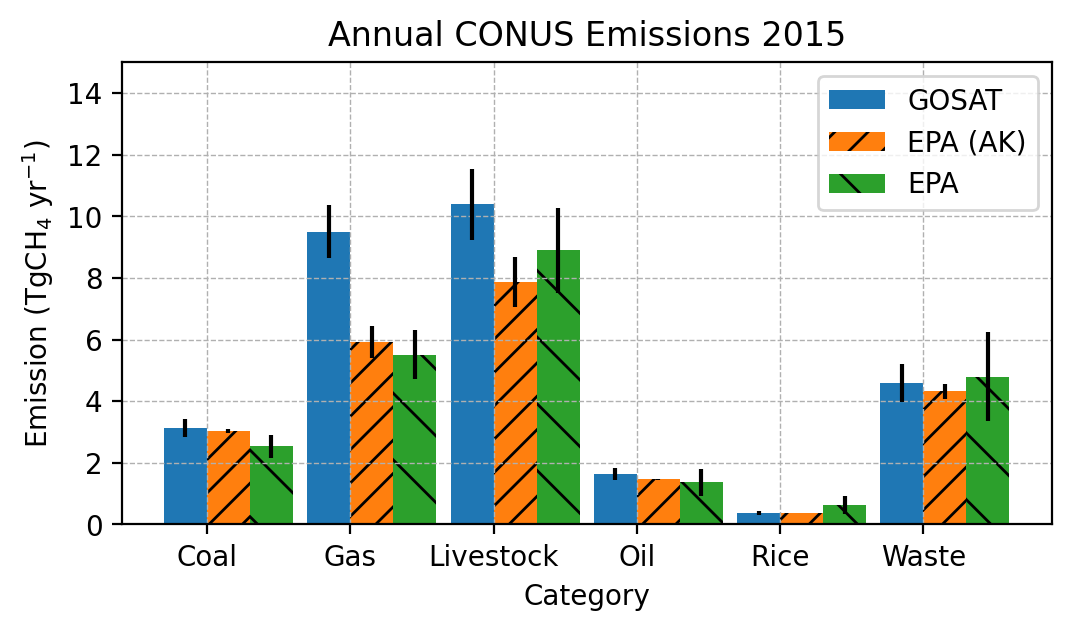

In [8]:
# Make a bar plot to compare the EPA inventory data with the GOSAT inversion data
makeBarPlot(ana_dict, epa_error_params, inventory="epa", analysis_year=analysis_year)



In the bar plot, the difference between the orange and green bars is due to the averaging kernel of the GOSAT flux inversion. The orange bar should be compared with the GOSAT estimates (blue bars).

Country United States not found in the shapefile.
Country United States not found in the shapefile.
Country United States not found in the shapefile.
Country United States not found in the shapefile.
****The output is a scrollable list of maps.***
Generating maps for category: livestock


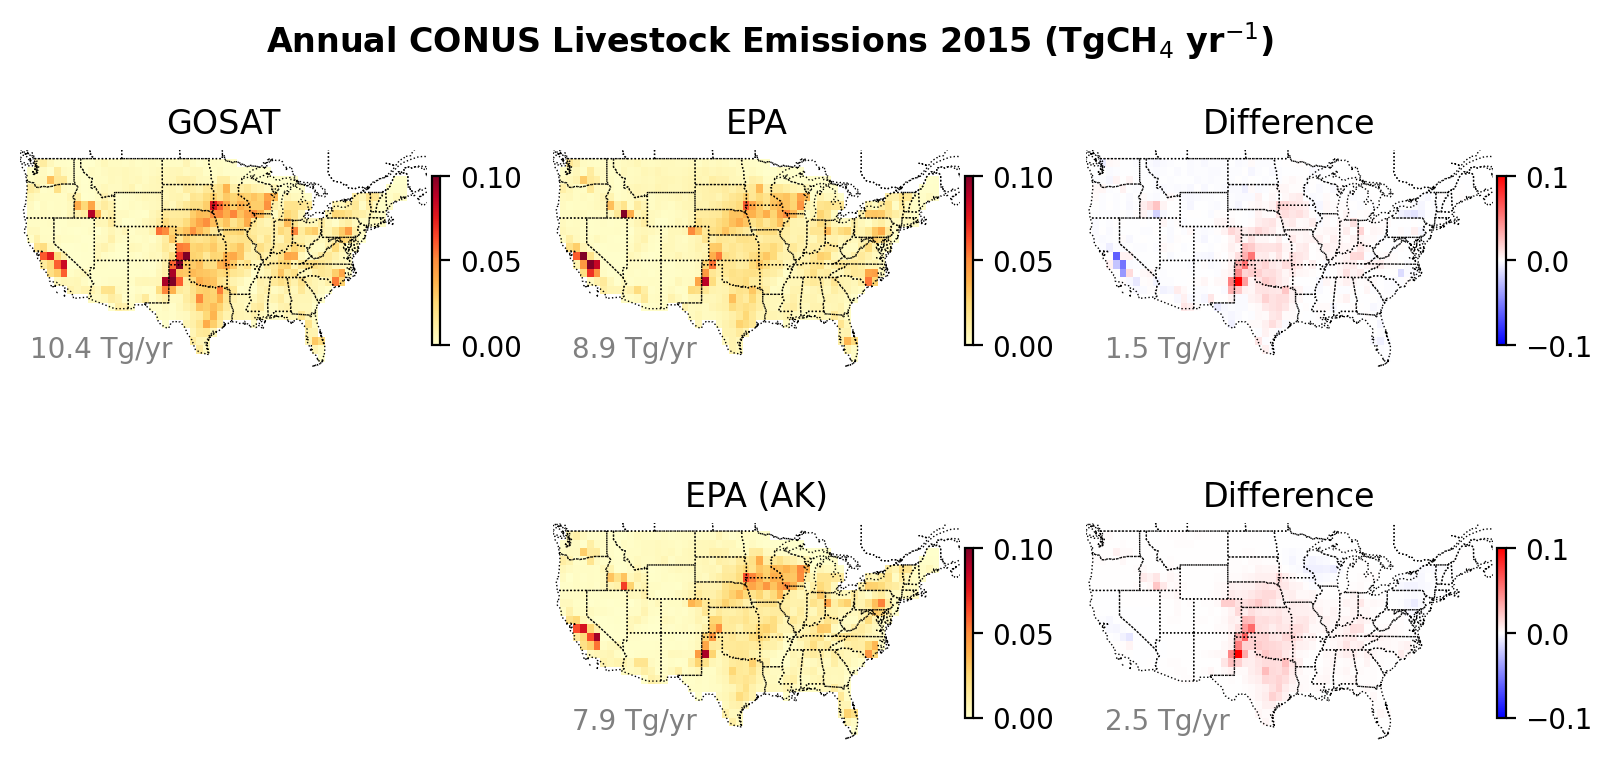

Generating maps for category: waste


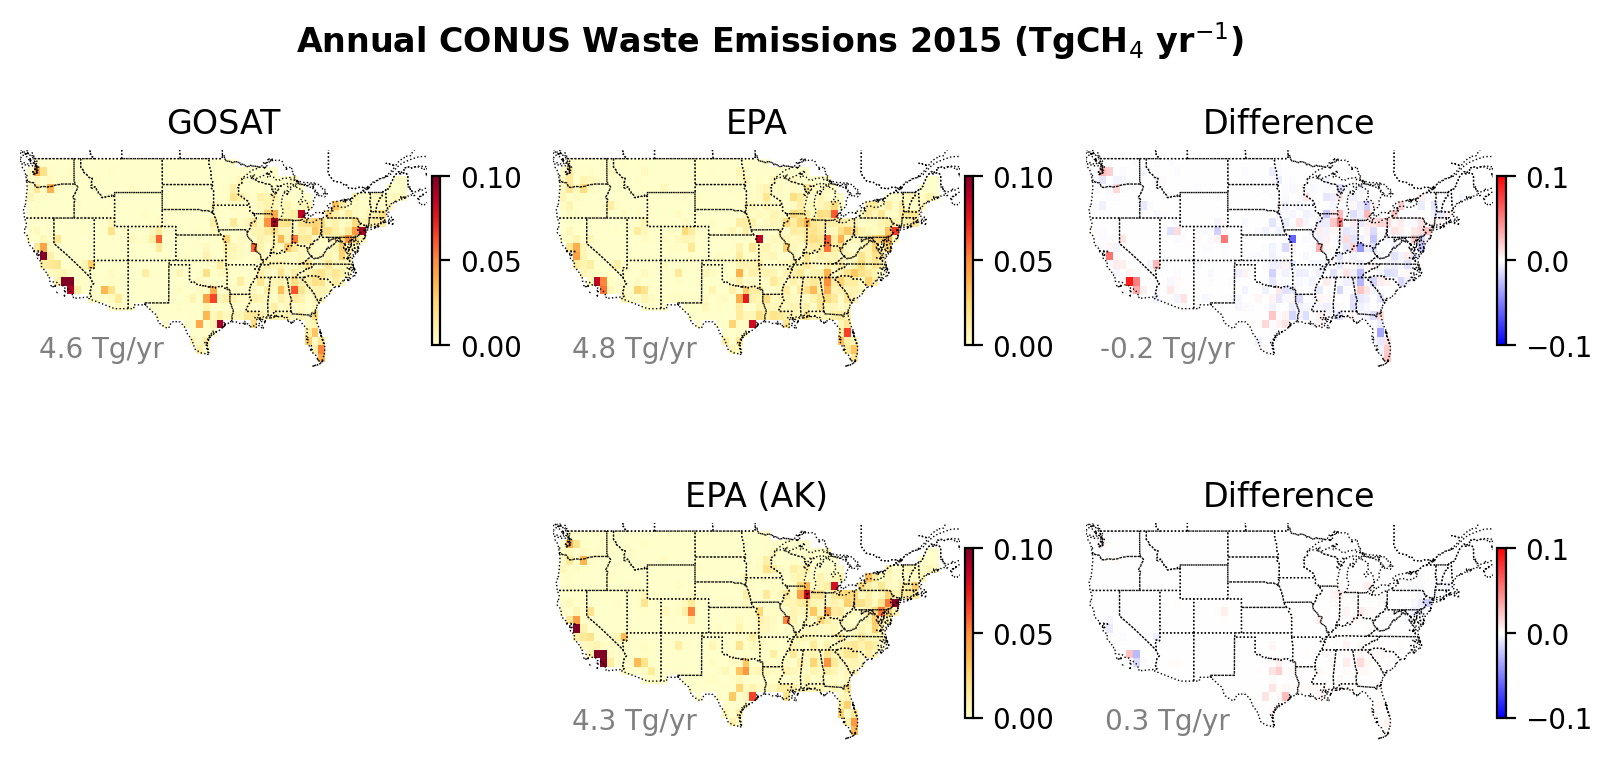

Generating maps for category: rice


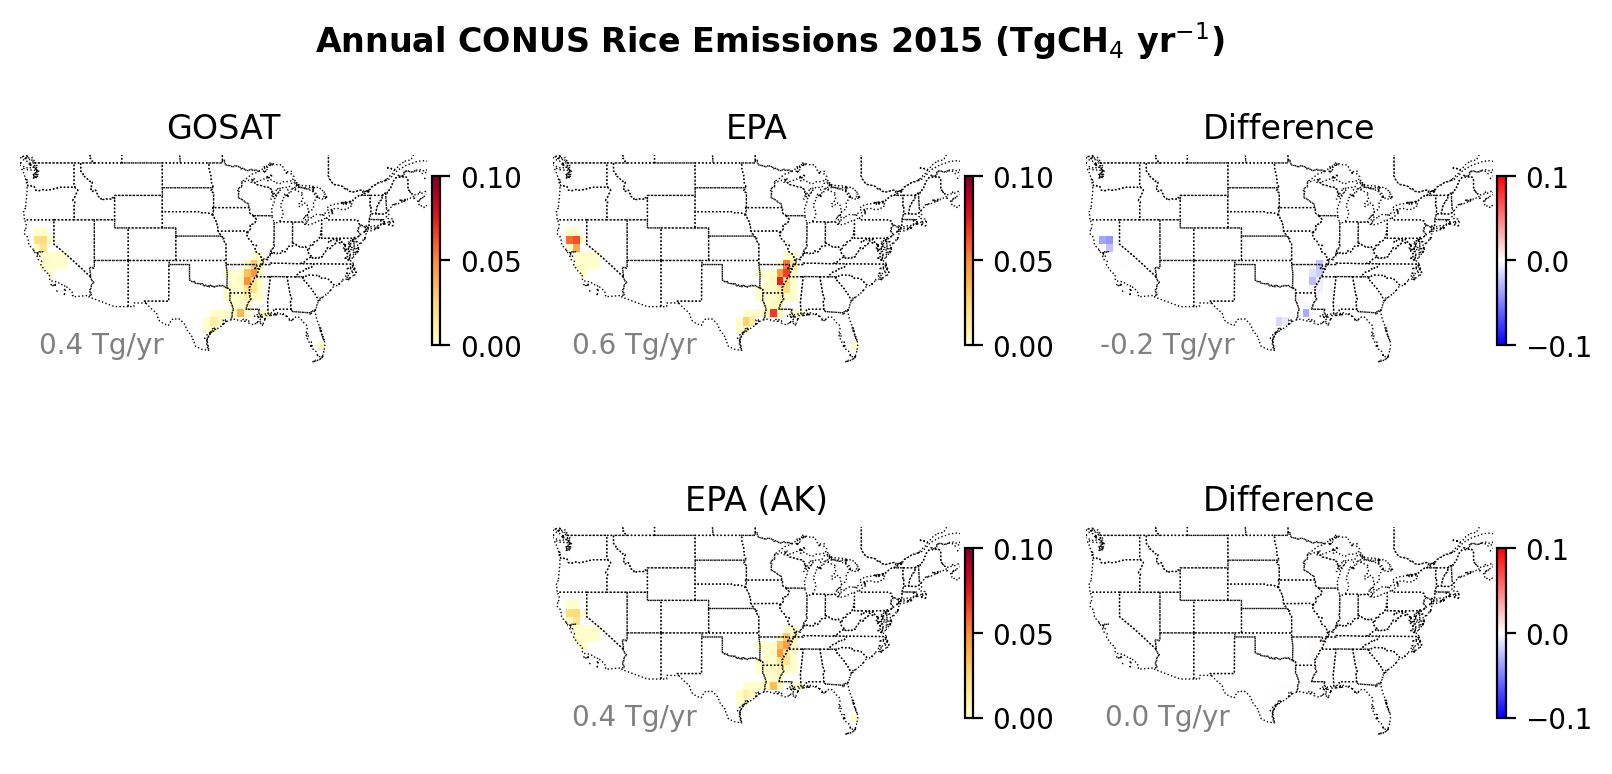

Generating maps for category: coal


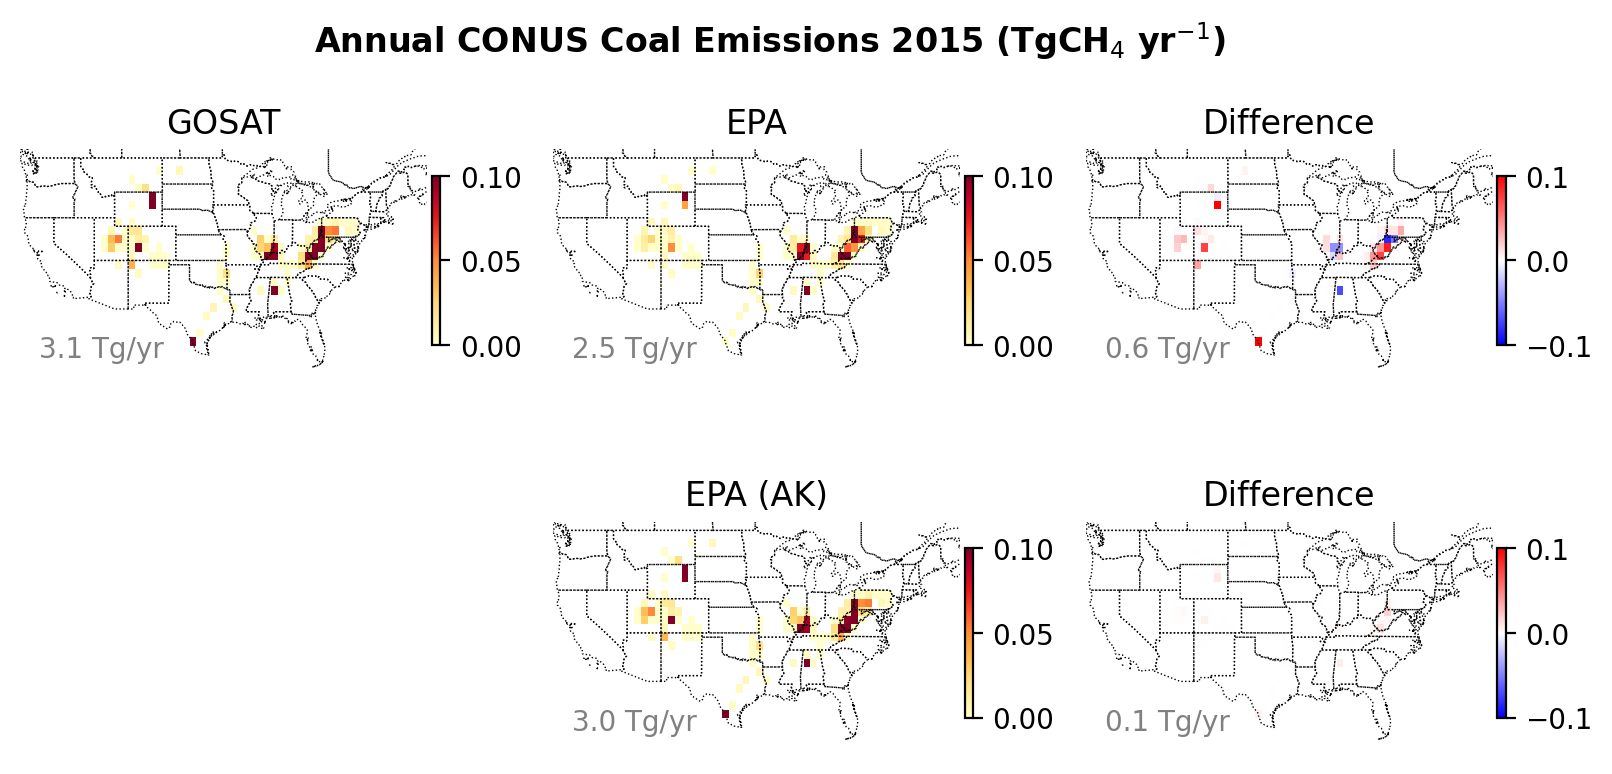

Generating maps for category: oil


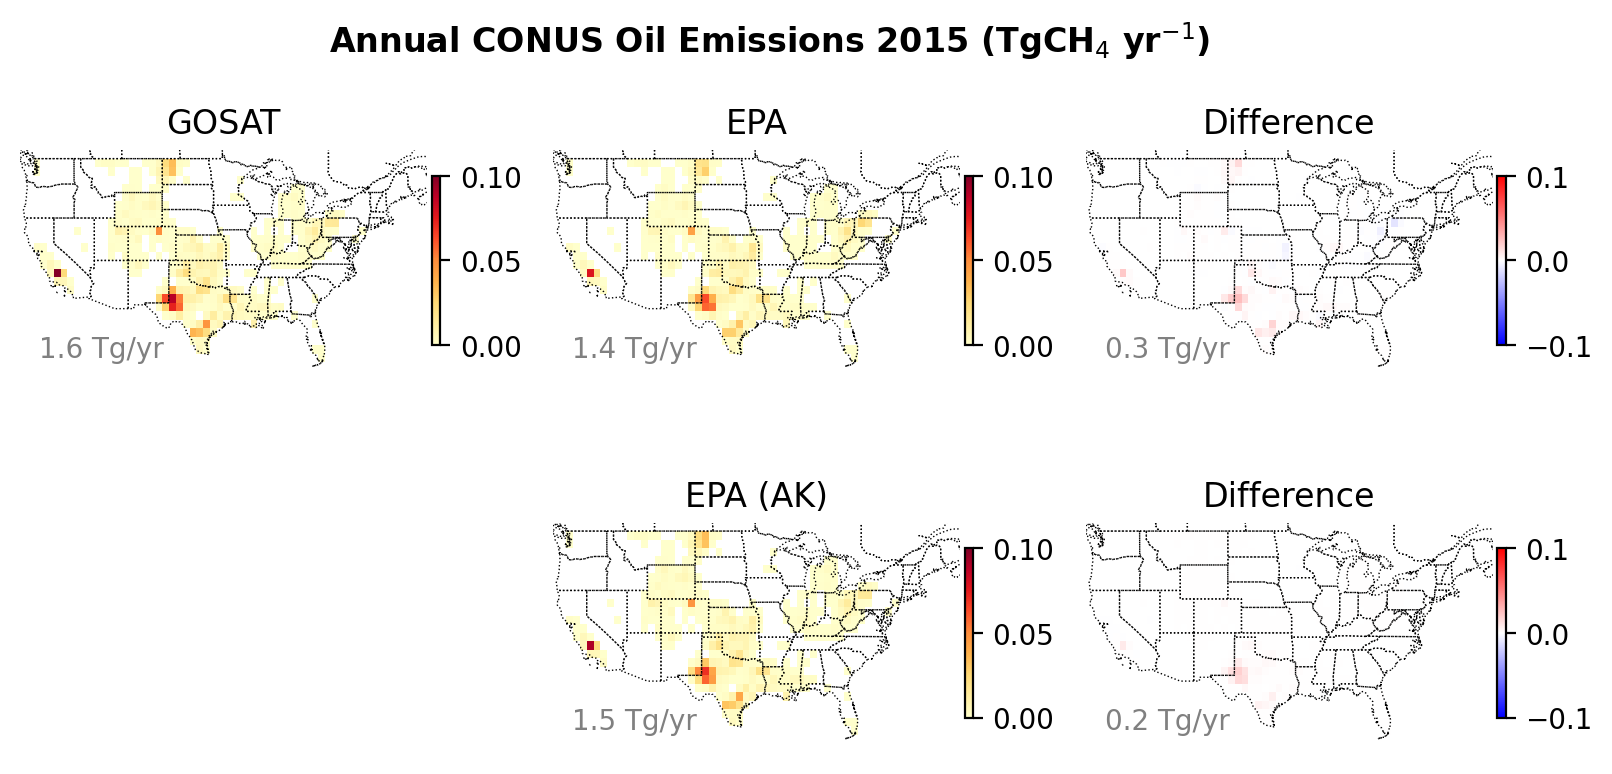

Generating maps for category: gas


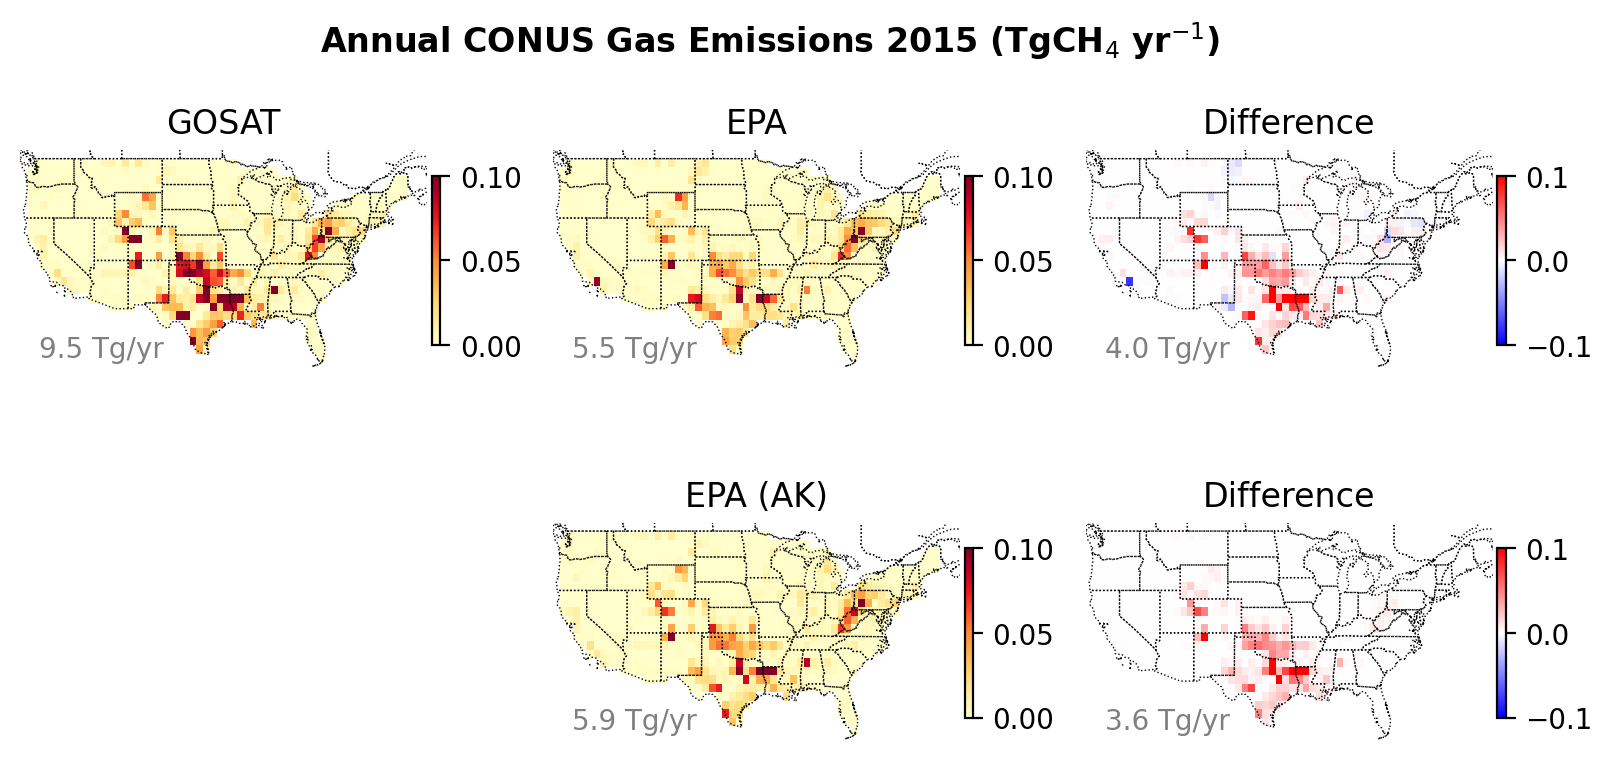

Output(layout=Layout(height='500px'))

In [9]:
# Create a GeoPandas DataFrame from the analysis dictionary for the "epa" inventory
gdf_epa = makeGeoPandasDataFrame(ana_dict, inventory="epa")

print ("****The output is a scrollable list of maps.***")
from ipywidgets import Output

# Iterate over each unique category in the 'cat' column of the GeoPandas DataFrame
out = Output(layout={'overflow_y': 'scroll', 'height': '500px'}) 
cats= list(gdf_epa['cat'].unique())
for cat in cats:
        print(f"Generating maps for category: {cat}")
    # For each category, generate map plots using the MakeMaps function
        MakeMaps(gdf_epa, cat, inventory="epa", analysis_year=analysis_year)
display(out)

In [10]:
# Create a GeoPandas DataFrame from the analysis dictionary for the "epa" inventory
gdf_epa = makeGeoPandasDataFrame(ana_dict, inventory="epa")

print ("****The output is a scrollable list of maps.***")
from ipywidgets import Output

# Iterate over each unique category in the 'cat' column of the GeoPandas DataFrame
out = Output(layout={'overflow_y': 'scroll', 'height': '500px'}) 
print (gdf_epa['cat'].unique())
with out:
    for cat in gdf_epa['cat'].unique():
        print (cat)
    # For each category, generate map plots using the MakeMaps function
        MakeMaps(gdf_epa, cat, inventory="epa", analysis_year= analysis_year)
display(out)


Country United States not found in the shapefile.
Country United States not found in the shapefile.
Country United States not found in the shapefile.
Country United States not found in the shapefile.
****The output is a scrollable list of maps.***
['livestock' 'waste' 'rice' 'coal' 'oil' 'gas']


Output(layout=Layout(height='500px'))

The difference between the two middle panels of each sector plot is due to the averaging kernel of the GOSAT flux inversion.

# EDGAR inventory
Emissions Database for Global Atmospheric Research (EDGAR) Version 6 


Monforti Ferrario, Fabio; Crippa, Monica; Guizzardi, Diego; Muntean, Marilena; Schaaf, Edwin; Lo Vullo, Eleonora; Solazzo, Efisio; Olivier, Jos; Vignati, Elisabetta (2021): EDGAR v6.0 Greenhouse Gas Emissions. European Commission, Joint Research Centre (JRC) [Dataset]. 




In [11]:
# Read and process EDGAR inventory data for the specified analysis year
edgar_data_folder = data_folder_path + "/EDGAR_v6_2015_only/"
edgar_dat = readEdgarData(edgar_data_folder, analysis_year=analysis_year)

# Integrate EDGAR inventory data into the analysis dictionary (ana_dict) for the year 2015
ana_dict = addEdgar2AnaDict(ana_dict, edgar_dat, analysis_year=2015)
# ana_dict = FilterforCONUS(ana_dict)

Reading Edgar emission inventory Data for 2015
Adding Edgar data to ana_dict


Note: We assume that EDGAR has the same sector-wise uncertainity as EPA. 

In [12]:
# Perform AK correction on the analysis dictionary focusing on EDGAR data variables ("x_edgar" and "S_edgar")
ana_dict_edgar = performAKcorrection(ana_dict, x_var="x_edgar", S_var="S_edgar")

Performing GOSAT flux inversions AK Correction


Country United States not found in the shapefile.
Country United States not found in the shapefile.
Country United States not found in the shapefile.
Country United States not found in the shapefile.


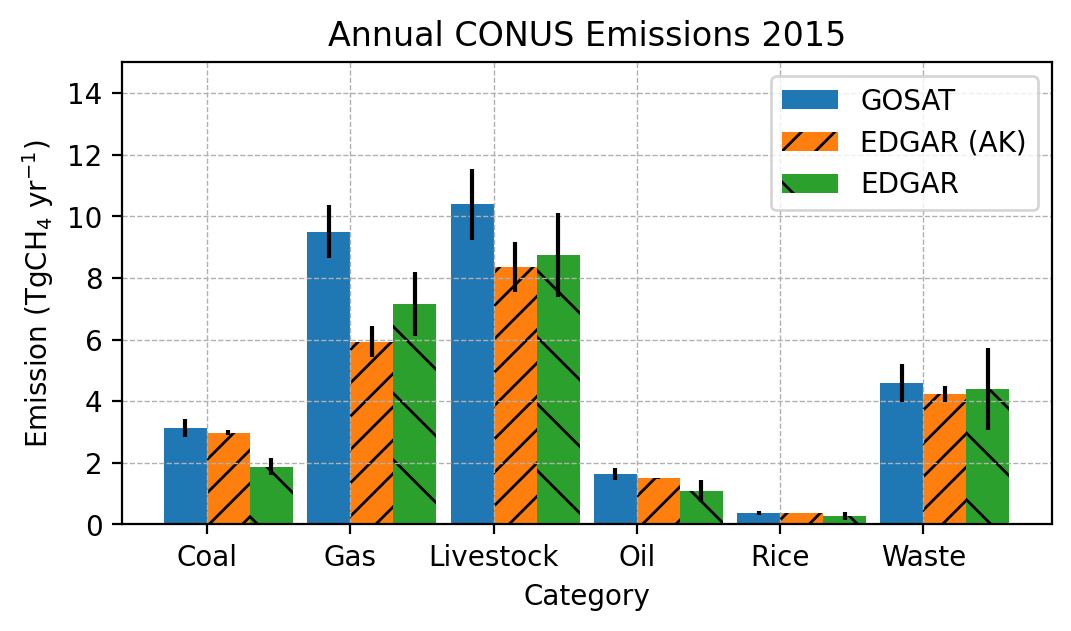

In [13]:
# Plot comparison of EDGAR and GOSAT total emissions for each sector. 
makeBarPlot(ana_dict_edgar, epa_error_params, inventory="edgar", analysis_year=analysis_year)

In [14]:
# Create a GeoPandas DataFrame from the analysis dictionary for the "edgar" inventory
gdf = makeGeoPandasDataFrame(ana_dict, inventory="edgar")
print ("***The output is a scrollable list of maps.***")
out = Output(layout={'overflow_y': 'scroll', 'height': '500px'})


# Iterate over each unique category in the 'cat' column of the GeoPandas DataFrame
with out:
    for cat in gdf['cat'].unique():
        # For each category, generate map plots using the MakeMaps function
        MakeMaps(gdf, cat, inventory="edgar", analysis_year= analysis_year)
display(out)


Country United States not found in the shapefile.
Country United States not found in the shapefile.
Country United States not found in the shapefile.
Country United States not found in the shapefile.
***The output is a scrollable list of maps.***


Output(layout=Layout(height='500px'))

# FOG Oil/Gas Fuel Inventory 
Francoeur, C. B., McDonald, B. C., Gilman, J. B., Zarzana, K. J., Dix, B., Brown, S. S., de Gouw, J. A., Frost, G. J., Li, M., McKeen, S. A., Peischl, J., Pollack, I. B., Ryerson, T. B., Thompson, C., Warneke, C., and Trainer, M.: Quantifying Methane and Ozone Precursor Emissions from Oil and Gas Production Regions across the Contiguous US, Environ. Sci. Technol., 55, 9129–9139, https://doi.org/10.1021/acs.est.0c07352, 2021.

Note: We assume that FOG emissions have the same uncertainty as EPA oil/gas emissions.

In [15]:
# Create a oil/Gas fuel category within the GOSAT data dictionary to accommodate FOG emissions data
ana_dict_fog = createFossilCategory(ana_dict)

# Adjust the resolution of the FOG data to match the GOSAT data dictionary's resolution
# This involves clustering or aggregating the FOG data, which has a native resolution of 4x4 km^2
fog_data_path = data_folder_path
ana_dict_fog = clusterFOG2GOSAT(fog_data_path, ana_dict_fog, analysis_year)

Creating Oil/Gas(= oil + gas) production Category
Clustering FOG data to GOSAT Grid Resolution


In [17]:
# Perform AK correction for the oil/gas category using EPA data
print("EPA fossil:", end=" ")
ana_dict_fog = performAKcorrection(ana_dict_fog, x_var="x_epa", S_var="S_epa")


# Perform AK correction for the oil/gas category using FOG data
print("FOG fossil:", end=" ")
ana_dict_fog = performAKcorrection(ana_dict_fog, x_var="x_fog", S_var="S_fog")

# Perform AK correction for the oil/gas category using EDGAR data
print("EDGAR fossil:", end=" ")
ana_dict_fog = performAKcorrection(ana_dict_fog, x_var="x_edgar", S_var="S_edgar")

# Modify the error parameters for the oil/gas category to include contributions from gas and oil.
# This step assumes that the "gas" key in the `epa_error_params` dictionary is a placeholder and needs to be updated.
epa_error_params["fossil"] = epa_error_params["gas"]  # This line needs modification to accurately represent fossil sources.

EPA fossil: Performing GOSAT flux inversions AK Correction
FOG fossil: Performing GOSAT flux inversions AK Correction
EDGAR fossil: Performing GOSAT flux inversions AK Correction


Country United States not found in the shapefile.
Country United States not found in the shapefile.
Country United States not found in the shapefile.
Country United States not found in the shapefile.


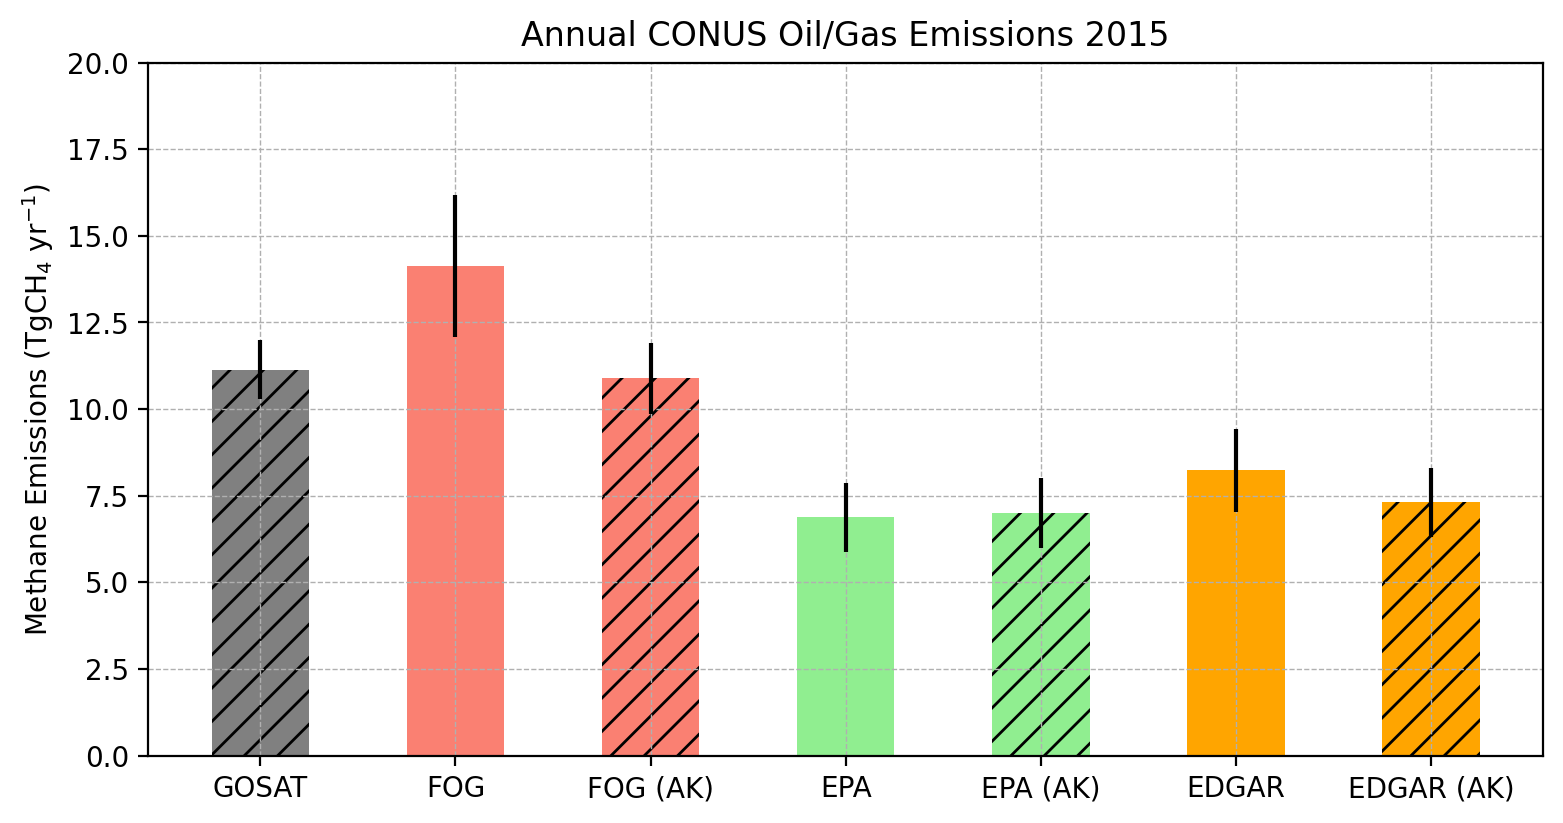

In [18]:
# Bar plot of oil/gas emissions from the three inventories and GOSAT flux inversion
makeBarPlotFossil(ana_dict_fog, epa_error_params, inventory="epa", analysis_year=analysis_year)

The FOG estimates are in good agreement with GOSAT inversion estimates after applying the GOSAT averaging kernel. EPA and EDGAR estimates agree with each other (after applying GOSAT averaging kernel) but underestimate the GOSAT inversion and FOG estimates.



Country United States not found in the shapefile.
Country United States not found in the shapefile.
Country United States not found in the shapefile.
Country United States not found in the shapefile.


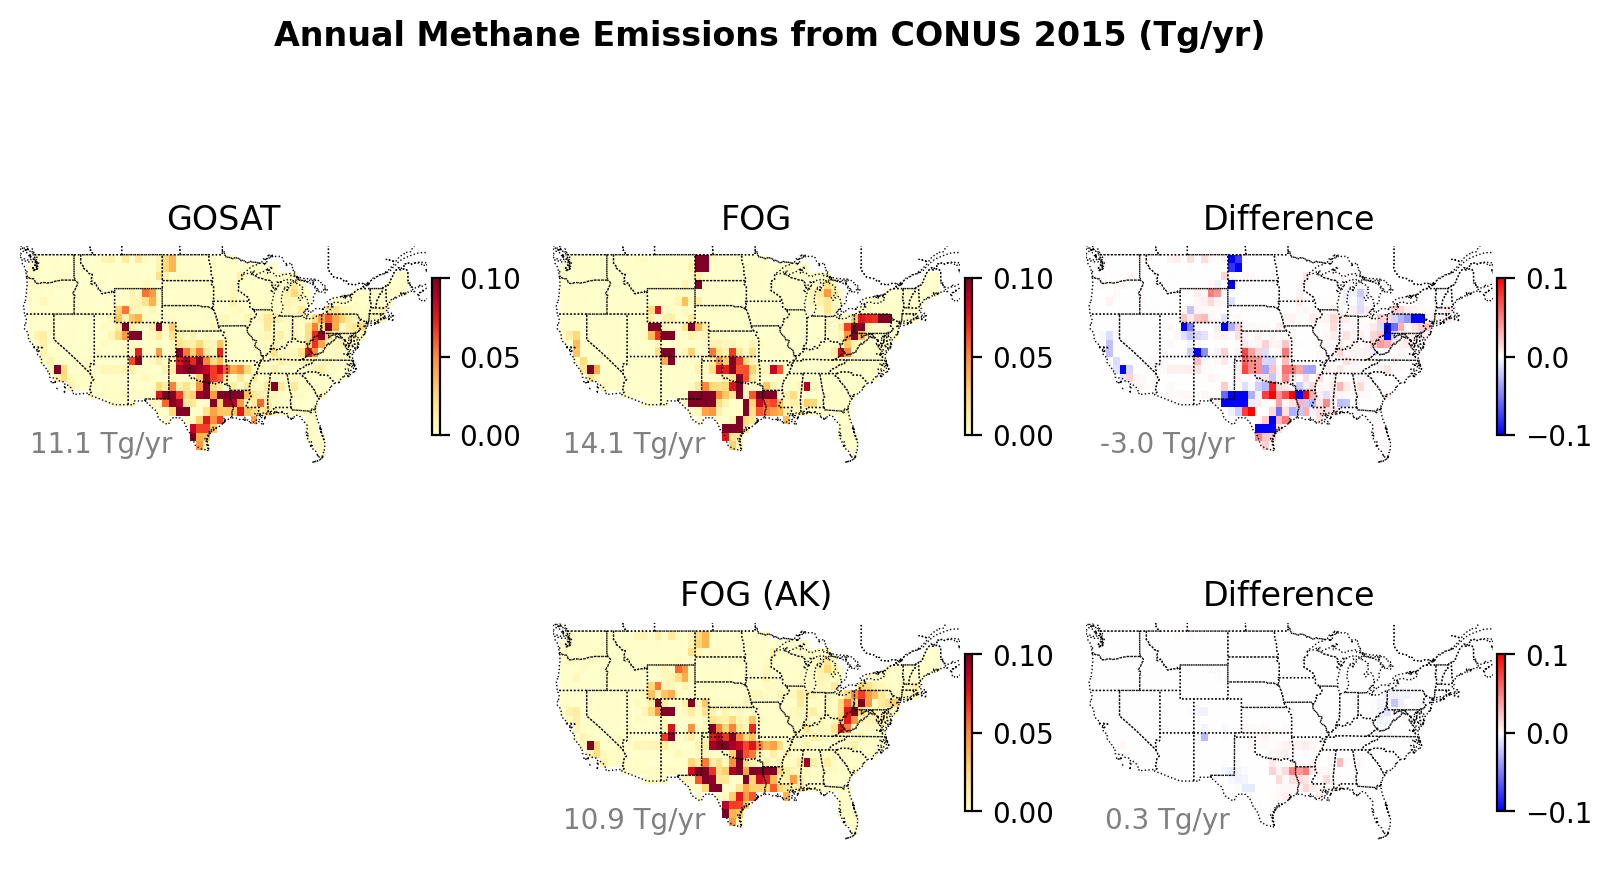

In [19]:
# Create map plots for fossil fuel emissions

# First, convert the analysis data into a GeoPandas DataFrame suitable for mapping
gdf_fog = makeGeoPandasDataFrameFOG(ana_dict_fog)

# Then, use the GeoPandas DataFrame to create maps of fossil fuel emissions for the specified analysis year
MakeFossilMaps(gdf_fog, analysis_year)

## Conclusion

1. **Importance of Averaging Kernels:**
   Accounting for truth sensitivity through the averaging kernel of flux inversions is essential for accurately evaluating methane emission inventories. This ensures that comparisons between bottom-up inventories and top-down satellite estimates are valid and reliable.

2. **Inventory Performance:**
   The Fossil Oil and Gas (FOG) estimates closely align with GOSAT flux inversion results after applying the averaging kernel. In contrast, the EPA and EDGAR inventories, while consistent with each other after correction, tend to underestimate methane emissions compared to satellite-derived estimates.

3. **Implications and Future Directions:**
   The underestimation by EPA and EDGAR suggests a need to enhance their methodologies by incorporating satellite-based data and refining emission factors.

---

This analysis highlights the necessity of integrating satellite-based flux inversions with traditional emission inventories to achieve a more accurate and comprehensive understanding of methane emissions. Addressing the identified discrepancies will improve emission assessments and inform better policy and mitigation efforts.